In [1]:
#  Q10 - Ad- Agency User click prediction

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', 0)
plt.style.use('ggplot')

In [48]:
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
import random
import gzip


In [19]:
n= 1048576
s= 200000
skip = sorted(random.sample(range(n),n-s))
#df = pandas.read_csv(filename, skiprows=skip)
train=pd.read_csv("/content/sample_data/train.csv", skiprows=skip)
train.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000126e+19,0,14102100,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,c357dbff,f1ac7184,373ecbe6,0,0,21689,320,50,2496,3,167,100191,23
1,1.000187e+19,0,14102100,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,5d877109,8f5c9827,1,0,17747,320,50,1974,2,39,100019,33


In [20]:
train.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [21]:
train.shape

(199999, 24)

In [11]:
n= 1048576
s= 200000
skip = sorted(random.sample(range(n),n-s))
#df = pandas.read_csv(filename, skiprows=skip)
test=pd.read_csv("/content/sample_data/test.csv", skiprows=skip)
test.head()

,10000174058809200000.00,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,69f45779,0eb711ec,1,0.1,8330,320,50,761,3,175,100075,23
0,1.000109e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,a99f214a,422d257a,542422a7,1.0,0.0,18648.0,320.0,50.0,1092.0,3.0,809.0,100156.0,61.0
1,1.000200e+19,14103100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,dc17d849,ac9ad752,1.0,0.0,23642.0,320.0,50.0,2709.0,3.0,39.0,-1.0,23.0
2,1.000459e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,e2a1ca37,2347f47a,8ded1f7a,a99f214a,9f91c894,dc70b0f9,1.0,0.0,17016.0,320.0,50.0,1873.0,3.0,39.0,100065.0,23.0
3,1.000460e+19,14103100,1012,0,8ab5bdcf,db11867b,c0dd3be3,ecad2386,7801e8d9,07d7df22,a99f214a,70c55f7e,8a4875bd,1.0,0.0,23723.0,320.0,50.0,2716.0,3.0,47.0,-1.0,23.0
4,1.000559e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,ce183bbd,ae637522,cef3e649,a99f214a,df8d72b4,36b67a2a,1.0,0.0,23866.0,320.0,50.0,2736.0,0.0,33.0,-1.0,246.0


In [14]:
test.shape

(61172, 23)

In [22]:
train['hour'].isnull().sum()

0

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                199999 non-null  float64
 1   click             199999 non-null  int64  
 2   hour              199999 non-null  int64  
 3   C1                199999 non-null  int64  
 4   banner_pos        199999 non-null  int64  
 5   site_id           199999 non-null  object 
 6   site_domain       199999 non-null  object 
 7   site_category     199999 non-null  object 
 8   app_id            199999 non-null  object 
 9   app_domain        199999 non-null  object 
 10  app_category      199999 non-null  object 
 11  device_id         199999 non-null  object 
 12  device_ip         199999 non-null  object 
 13  device_model      199999 non-null  object 
 14  device_type       199999 non-null  int64  
 15  device_conn_type  199999 non-null  int64  
 16  C14               19

In [25]:
train['hour'] = pd.to_datetime(train['hour'], format='%y%m%d%H')

In [26]:
train['month'] = train['hour'].dt.month
train['dayofweek'] = train['hour'].dt.dayofweek
train['day'] = train['hour'].dt.day
train['hour_time'] = train['hour'].dt.hour
train.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
0,1.000126e+19,0,2014-10-21,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,c357dbff,f1ac7184,373ecbe6,0,0,21689,320,50,2496,3,167,100191,23,10,1,21,0
1,1.000187e+19,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,5d877109,8f5c9827,1,0,17747,320,50,1974,2,39,100019,33,10,1,21,0


In [27]:
train.isnull().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
month               0
dayofweek           0
day                 0
hour_time           0
dtype: int64

In [28]:
numerical = []
categorical = []

for col in (train.columns):
    if train[col].dtype == "object":
        categorical.append(col)
    else:
        numerical.append(col)
print("numerical columns = ",numerical)
print("\ncategorical columns = ",categorical)

numerical columns =  ['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'month', 'dayofweek', 'day', 'hour_time']

categorical columns =  ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


0    0.840724
1    0.159276
Name: click, dtype: float64




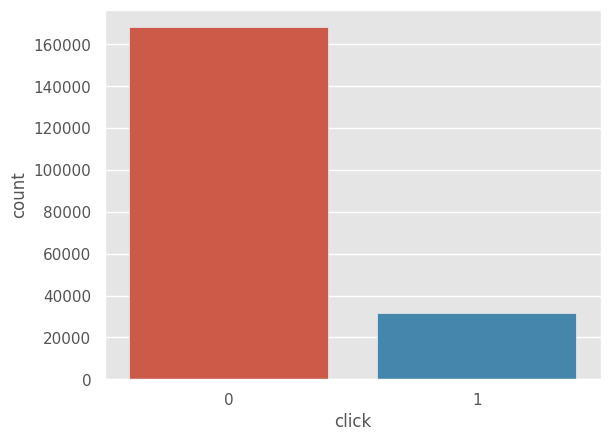

In [29]:
print(train.click.value_counts(normalize = True))
print("\n")
plt.figure()
sns.countplot(x='click', data=train)
plt.show()

In [30]:
train.drop(['id', 'hour'], axis = 1, inplace = True) 
train.rename(columns={'click': 'y',
                   'hour_time': 'hour'},
          inplace=True)

In [31]:
sampled_data = train.sample(frac=0.1, random_state=42)
X = sampled_data.drop(['y'], axis=1)
y = sampled_data['y']

In [32]:
train.y.value_counts(normalize = True)

0    0.840724
1    0.159276
Name: y, dtype: float64

In [36]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 8.8 MB/s eta 0:00:00


In [37]:
import category_encoders as ce
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)
X.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour
134252,1005,0,0.051645,0.051645,0.177049,0.191223,0.185013,0.189900,0.171410,0.140574,0.136638,1,0,19251,320,50,2201,3,35,100210,43,10,1,21,4
124140,1005,0,0.101484,0.103230,0.108388,0.132824,0.132824,0.104421,0.270683,0.270683,0.073620,1,0,19251,320,50,2201,3,35,-1,43,10,1,21,3


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size= 0.3, random_state= 42)

In [39]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [41]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head()
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour
99648,0.363636,0.000000,0.316764,0.316764,0.883196,0.511783,0.608097,0.835293,0.296708,0.699582,0.356376,0.2,0.4,0.718693,0.203125,0.031532,0.675052,0.0,0.0,0.0,0.362637,0.0,0.0,0.0,0.6
164415,0.363636,0.142857,0.151994,0.154095,0.732860,0.511783,0.608097,0.835293,0.296708,0.257367,0.220060,0.2,0.0,0.884992,0.203125,0.031532,0.875891,1.0,0.0,0.0,0.164835,0.0,0.0,0.0,0.8


In [43]:
# this function helps in evaluation the given model and provide accuracy and confusion matrix. 

def model_eval(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

    return accuracy, cnf_matrix

In [44]:
y_pred = model.predict(X_test)
accuracy, cnf_matrix = model_eval(model, X_test, y_test)
print(accuracy)
print(cnf_matrix)


0.8288333333333333
[[4864  166]
 [ 861  109]]


In [45]:
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train, y_train)
y_preds = dt_basic.predict(X_test)
accuracy, cnf_matrix = model_eval(dt_basic, X_test, y_test)
print(accuracy)
print(cnf_matrix)

0.9531666666666667
[[4889  141]
 [ 140  830]]


In [46]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_preds = model_rf.predict(X_test)
accuracy, cnf_matrix = model_eval(model_rf, X_test, y_test)
print(accuracy)
print(cnf_matrix)

0.9611666666666666
[[4940   90]
 [ 143  827]]


In [49]:
predict_rf = model_rf.predict(X_train)
predict_rf_test = model_rf.predict(X_test)

accuracy, cnf_matrix = model_eval(model_rf, X_train, y_train)
print("Results for the Train data")
print("accuracy",accuracy)
print("cnf_matrix::", cnf_matrix)

accuracy, cnf_matrix = model_eval(model_rf, X_test, y_test)
print("Results for the Test data")
print("accuracy",accuracy)
print("cnf_matrix::", cnf_matrix)

Results for the Train data
accuracy 0.9980714285714286
cnf_matrix:: [[11728    10]
 [   17  2245]]
Results for the Test data
accuracy 0.9611666666666666
cnf_matrix:: [[4940   90]
 [ 143  827]]
